In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def clean_colnames(colname):
    cleaned_colname = colname.lower()
    cleaned_colname = re.sub(r'\W+', '_', cleaned_colname)
    return cleaned_colname

In [4]:
loan_df = pd.read_excel('C:/Users/USER/Downloads/LoanHistoricalData.xlsx')
loan_df.columns = [clean_colnames(colname) for colname in loan_df.columns]
loan_df = loan_df.drop(columns=['loan_ids'], axis=1)
print(loan_df.shape)
print(loan_df.columns)
loan_df.head(3)

(6000, 20)
Index(['good_bad_loan', 'covid_period_default_', 'recomended_loan_amt',
       'interest_rate', 'tenor', 'total_collateral_value', 'rec_basis',
       'fresh_topup', 'product', 'constitution', 'source_branch',
       'applicant_state', 'applicant_city', 'coborrower1_designation',
       'coborrower2_designation', 'coborrower1_cibilscore',
       'coborrower2_cibilscore', 'locality', 'years_of_operation',
       'total_income'],
      dtype='object')


,good_bad_loan,covid_period_default_,recomended_loan_amt,interest_rate,tenor,total_collateral_value,rec_basis,fresh_topup,product,constitution,source_branch,applicant_state,applicant_city,coborrower1_designation,coborrower2_designation,coborrower1_cibilscore,coborrower2_cibilscore,locality,years_of_operation,total_income
0,Bad,Yes,51055,14,35,NaN,Cashflows,Fresh,Unsecured,Trust,A,New Jersey,Nguyenberg,Chairman,Secretary,866.0,-1.0,SEMIU,8,8.607574e+06
1,Good,No,71357,14,43,2.826936e+07,Finance Ledgers,Fresh,Secured,Society,B,Maine,North Jimmyshire,Secretary,Trustee,866.0,368.0,RURAL,8,9.628977e+06
2,Bad,Yes,4127836,14,110,NaN,Cashflows,Fresh,Others,Society,C,Louisiana,Myersmouth,Managing Director,Trustee,566.0,862.0,RURAL,30,6.504837e+07


In [5]:
(
    loan_df
    .isnull()
    .sum()
    .rename('missing_freq')
    .sort_values(ascending=False)
    .loc[lambda x: x>0]
    .reset_index()
    .rename(columns={'index': 'colname'})
    .assign(missing_per=lambda x: (x['missing_freq']/loan_df.shape[0])*100)
)

,colname,missing_freq,missing_per
0,total_collateral_value,3729,62.150000
1,coborrower1_designation,51,0.850000
2,total_income,42,0.700000
3,coborrower2_cibilscore,31,0.516667
4,coborrower2_designation,28,0.466667
5,rec_basis,3,0.050000
6,coborrower1_cibilscore,1,0.016667
7,applicant_city,1,0.016667


In [6]:
loan_df['total_collateral_value'] = loan_df['total_collateral_value'].fillna(0)
loan_df = loan_df.dropna()

In [7]:
(
    loan_df
    .isnull()
    .sum()
    .rename('missing_freq')
    .sort_values(ascending=False)
    .loc[lambda x: x>0]
    .reset_index()
    .rename(columns={'index': 'colname'})
    .assign(missing_per=lambda x: (x['missing_freq']/loan_df.shape[0])*100)
)

,colname,missing_freq,missing_per


In [8]:
loan_df.nunique().rename('unique_count').sort_values(ascending=False)

total_income               5845
recomended_loan_amt        5826
applicant_city             4918
total_collateral_value     2223
coborrower2_cibilscore      586
coborrower1_cibilscore      580
tenor                       121
years_of_operation           61
applicant_state              50
source_branch                45
coborrower1_designation      13
coborrower2_designation      13
constitution                  6
rec_basis                     5
product                       3
locality                      3
covid_period_default_         2
fresh_topup                   2
good_bad_loan                 2
interest_rate                 1
Name: unique_count, dtype: int64

In [9]:
designation_order = ['CHAIRMAN', #0
 'PRESIDENT',
 'MANAGING DIRECTOR',
 'VICE PRESIDENT',
 'DIRECTOR',
 'SECRETARY',
 'TREASURER',
 'MANAGING TRUSTEE',
 'COMMITTEE MEMBER',
 'MEMBER',
 'TRUSTEE',
 'CORRESPONDENT',
 'OTHERS'] #weightage
designation_mapping = {designation: i for i, designation in enumerate(designation_order)}
loan_df['coborrower1_designation_ordinal'] = loan_df['coborrower1_designation'].str.upper().map(designation_mapping)
loan_df['coborrower2_designation_ordinal'] = loan_df['coborrower2_designation'].str.upper().map(designation_mapping)

loan_df['covid_period_default_'] = loan_df['covid_period_default_'].replace({'Yes': 1, 'No': 0})
loan_df['fresh_topup'] = loan_df['fresh_topup'].replace({'Fresh': 0, 'Top Up': 1})
loan_df['good_bad_loan'] = loan_df['good_bad_loan'].replace({'Bad': 1, 'Good': 0})

loan_df = loan_df.drop(columns=['interest_rate', 'coborrower1_designation', 'coborrower2_designation'], axis=1)

In [10]:
# Frequency encoding for 'applicant_city'
freq_encoding = loan_df.groupby('applicant_state').size() / len(loan_df)
loan_df['applicant_state'] = loan_df['applicant_state'].map(freq_encoding)

In [11]:
city_income_encoding = (loan_df.groupby('applicant_city')['total_income'].mean()/loan_df.groupby('applicant_city').size()).to_dict()
loan_df['applicant_city'] = loan_df['applicant_city'].map(city_income_encoding)

In [12]:
weighted_income_dict = (
    loan_df
    .groupby('source_branch')
    .agg(
        mean_income=('total_income', 'mean'),
        count_income=('total_income', 'size')
    )
    .assign(
        weighted_income=lambda x: (x['mean_income']/x['count_income'])*100
    )
    .loc[:, 'weighted_income']
    .to_dict()
)

loan_df['source_branch'] = loan_df['source_branch'].map(weighted_income_dict)

In [13]:
modeling_df = pd.get_dummies(loan_df, columns=['constitution', 'rec_basis', 'product', 'locality'], drop_first=True, dtype=int)

In [14]:
modeling_df.shape

(5845, 28)

In [15]:
X = modeling_df.drop(columns=['good_bad_loan'], axis=1)
Y = modeling_df['good_bad_loan']

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(4091, 27) (1754, 27) (4091,) (1754,)


In [17]:
Y_train.value_counts(), Y_test.value_counts()

(good_bad_loan
 1    2152
 0    1939
 Name: count, dtype: int64,
 good_bad_loan
 1    909
 0    845
 Name: count, dtype: int64)

In [18]:
categorical_cols = [
    'constitution_Partnership / LLP',
       'constitution_Private Limited Company',
       'constitution_Public Limited Company', 'constitution_Society',
       'constitution_Trust', 'rec_basis_Bank Credits', 'rec_basis_Cashflows',
       'rec_basis_Finance Audits', 'rec_basis_Finance Ledgers',
       'product_Secured', 'product_Unsecured', 'locality_SEMIU',
       'locality_URBAN', 'fresh_topup','covid_period_default_',
    'applicant_state', 'applicant_city','coborrower1_designation_ordinal',
    'coborrower2_designation_ordinal'
]


def check_chisquare(X, Y, categorical_cols):
  results = {}
  for col in categorical_cols:
    contingency_table = pd.crosstab(X[col], Y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    results[col] = {'chi2': chi2, 'p_value': p}
  return results


chisquare_results = check_chisquare(X_train, Y_train, categorical_cols)


for col, result in chisquare_results.items():
    print(f"Column: {col}")
    print(f"Chi2: {result['chi2']:.4f}")
    print(f"P-value: {result['p_value']:.4f}")
    if result['p_value'] < 0.05:
        print("Significant relationship with good_bad_loan\n")
    else:
        print("Not a significant relationship with good_bad_loan\n")

Column: constitution_Partnership / LLP
Chi2: 0.6115
P-value: 0.4342
Not a significant relationship with good_bad_loan

Column: constitution_Private Limited Company
Chi2: 0.0791
P-value: 0.7785
Not a significant relationship with good_bad_loan

Column: constitution_Public Limited Company
Chi2: 0.0027
P-value: 0.9584
Not a significant relationship with good_bad_loan

Column: constitution_Society
Chi2: 0.9703
P-value: 0.3246
Not a significant relationship with good_bad_loan

Column: constitution_Trust
Chi2: 1.0760
P-value: 0.2996
Not a significant relationship with good_bad_loan

Column: rec_basis_Bank Credits
Chi2: 1.7849
P-value: 0.1815
Not a significant relationship with good_bad_loan

Column: rec_basis_Cashflows
Chi2: 14.2539
P-value: 0.0002
Significant relationship with good_bad_loan

Column: rec_basis_Finance Audits
Chi2: 6.4469
P-value: 0.0111
Significant relationship with good_bad_loan

Column: rec_basis_Finance Ledgers
Chi2: 15.7839
P-value: 0.0001
Significant relationship with g

In [19]:
continous_cols = [colname for colname in X.columns if colname not in categorical_cols]

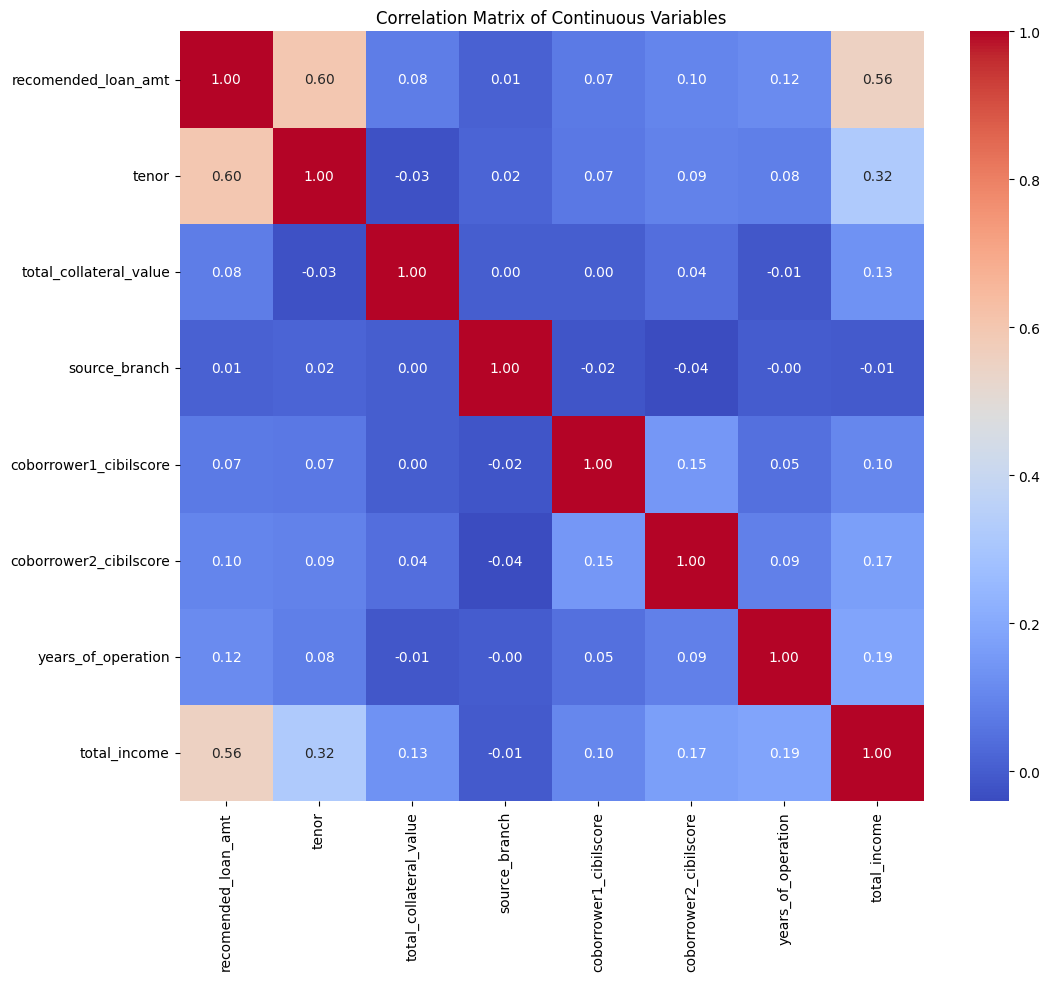

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X_train[continous_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

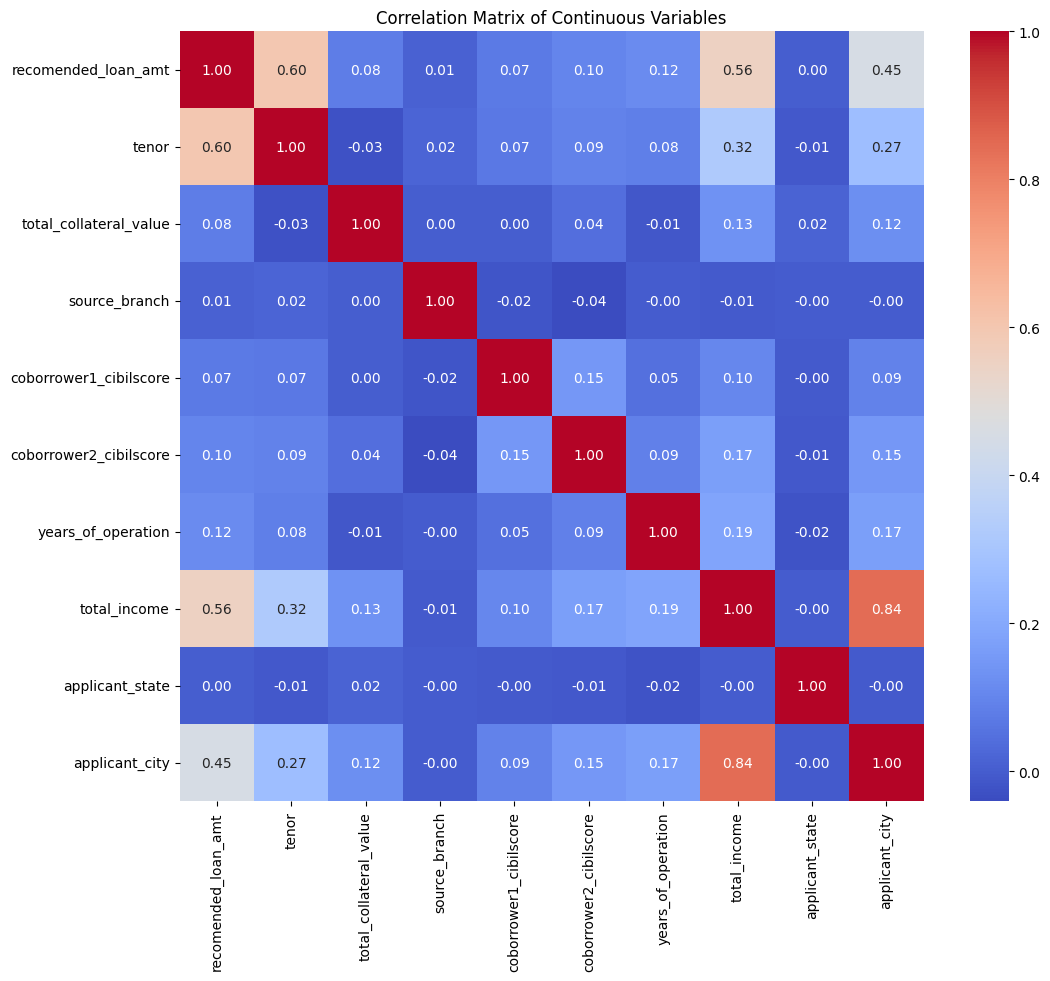

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X_train[continous_cols+ ['applicant_state', 'applicant_city']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# Initialize the Logistic Regression model
logreg = LogisticRegression(solver='liblinear')

# Create the RFE object and rank each feature
rfe = RFE(estimator=logreg, n_features_to_select=10) # Select top 10 features, adjust as needed
rfe = rfe.fit(X_train, Y_train)

# Get the ranking of the features
feature_ranking = pd.DataFrame({'Feature': X_train.columns, 'Ranking': rfe.ranking_})

# Print the features and their ranking
print(feature_ranking.sort_values(by='Ranking'))

# Get the important features
important_features = X_train.columns[rfe.support_]
print("\nImportant Features:")
important_features

(4091, 27) (1754, 27) (4091,) (1754,)
                                 Feature  Ranking
13       coborrower2_designation_ordinal        1
1                    recomended_loan_amt        1
2                                  tenor        1
3                 total_collateral_value        1
12       coborrower1_designation_ordinal        1
5                          source_branch        1
11                          total_income        1
7                         applicant_city        1
8                 coborrower1_cibilscore        1
9                 coborrower2_cibilscore        1
0                  covid_period_default_        2
10                    years_of_operation        3
20                   rec_basis_Cashflows        4
18                    constitution_Trust        5
24                     product_Unsecured        6
17                  constitution_Society        7
22             rec_basis_Finance Ledgers        8
23                       product_Secured        9
25          

Index(['recomended_loan_amt', 'tenor', 'total_collateral_value',
       'source_branch', 'applicant_city', 'coborrower1_cibilscore',
       'coborrower2_cibilscore', 'total_income',
       'coborrower1_designation_ordinal', 'coborrower2_designation_ordinal'],
      dtype='object')

(4091, 9) (1754, 9) (4091,) (1754,)
Optimization terminated successfully.
         Current function value: 0.688882
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          good_bad_loan   No. Observations:                 4091
Model:                          Logit   Df Residuals:                     4081
Method:                           MLE   Df Model:                            9
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                0.004205
Time:                        22:44:59   Log-Likelihood:                -2818.2
converged:                       True   LL-Null:                       -2830.1
Covariance Type:            nonrobust   LLR p-value:                  0.004623
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                         

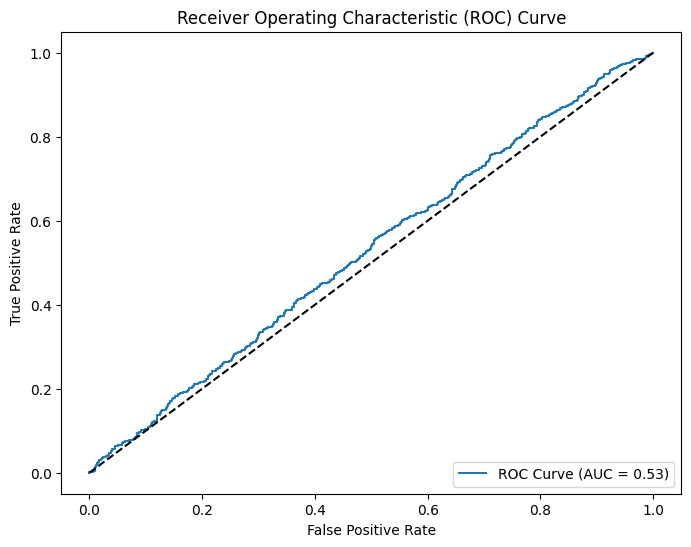

In [63]:
import statsmodels.api as sm

required_cols = [ 'tenor', 'total_collateral_value',
       'source_branch', 'applicant_city', 'coborrower1_cibilscore',
       'coborrower2_cibilscore', 'total_income',
       'coborrower1_designation_ordinal', 'coborrower2_designation_ordinal']
model_X = X.loc[:, required_cols].copy()

X_train, X_test, Y_train, Y_test = train_test_split(model_X, Y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# Add a constant to the independent variables
X_train_sm = sm.add_constant(X_train)

# Fit the logistic regression model
logreg_model = sm.Logit(Y_train, X_train_sm).fit()

# Print the model summary
print(logreg_model.summary())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming logreg_model is your fitted logistic regression model and X_test, Y_test are your test data
# Get predictions
Y_pred_prob = logreg_model.predict(sm.add_constant(X_test))
Y_pred = (Y_pred_prob >= 0.5).astype(int)  # Adjust threshold as needed

# Calculate metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

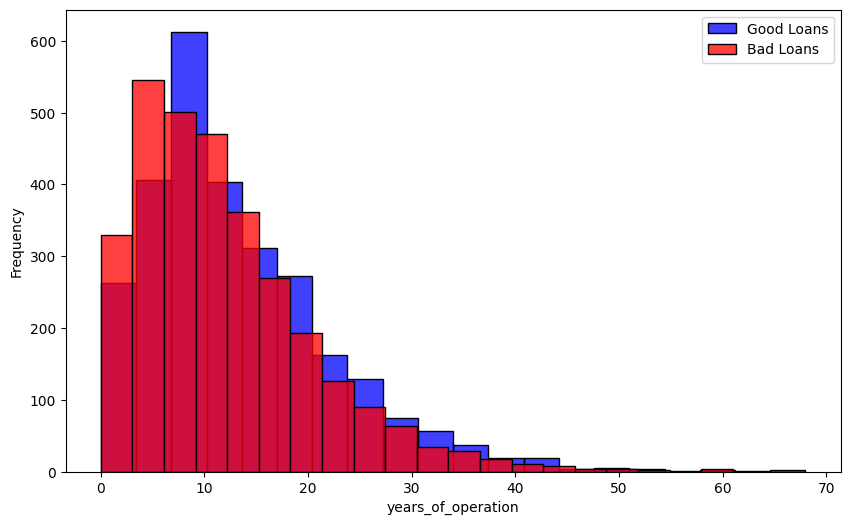

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(loan_df[loan_df['good_bad_loan'] == 0]['years_of_operation'], kde=False, bins=20, color='blue', label='Good Loans')
sns.histplot(loan_df[loan_df['good_bad_loan'] == 1]['years_of_operation'], kde=False, bins=20, color='red', label='Bad Loans')
plt.xlabel('years_of_operation')
plt.ylabel('Frequency')
plt.legend()
plt.show()

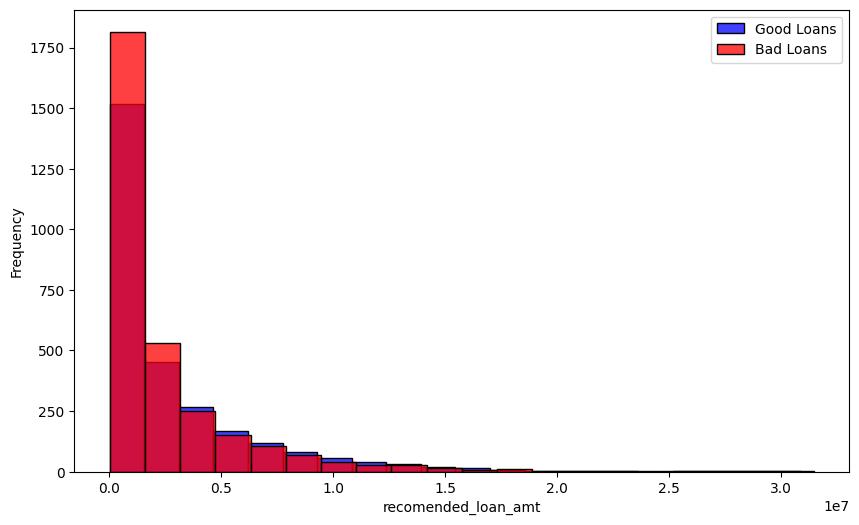

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(loan_df[loan_df['good_bad_loan'] == 0]['recomended_loan_amt'], kde=False, bins=20, color='blue', label='Good Loans')
sns.histplot(loan_df[loan_df['good_bad_loan'] == 1]['recomended_loan_amt'], kde=False, bins=20, color='red', label='Bad Loans')
plt.xlabel('recomended_loan_amt')
plt.ylabel('Frequency')
plt.legend()
plt.show()

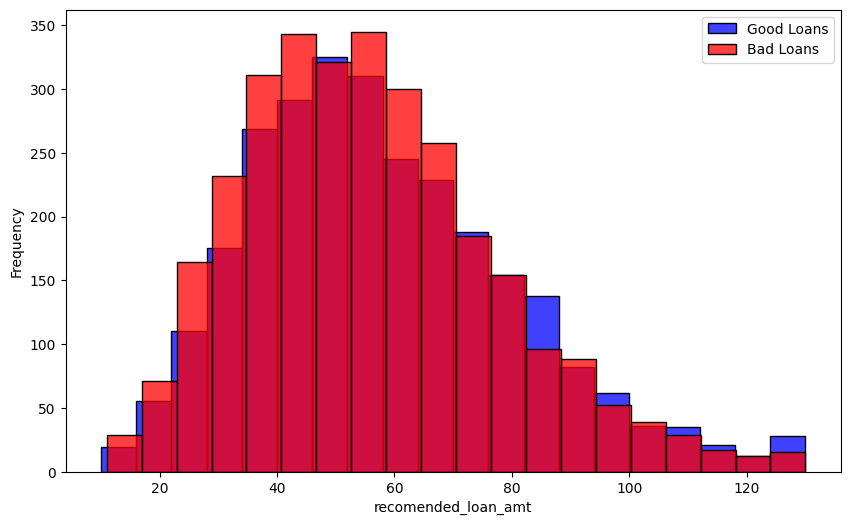

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(loan_df[loan_df['good_bad_loan'] == 0]['tenor'], kde=False, bins=20, color='blue', label='Good Loans')
sns.histplot(loan_df[loan_df['good_bad_loan'] == 1]['tenor'], kde=False, bins=20, color='red', label='Bad Loans')
plt.xlabel('recomended_loan_amt')
plt.ylabel('Frequency')
plt.legend()
plt.show()

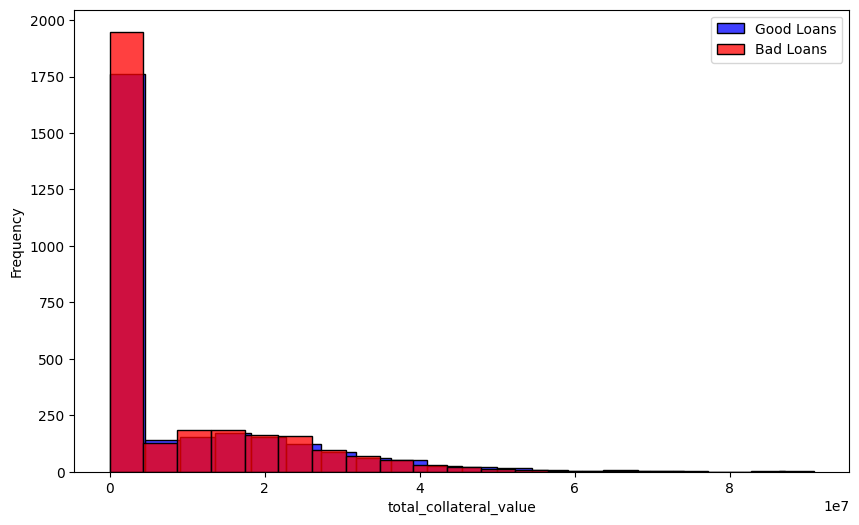

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(loan_df[loan_df['good_bad_loan'] == 0]['total_collateral_value'], kde=False, bins=20, color='blue', label='Good Loans')
sns.histplot(loan_df[loan_df['good_bad_loan'] == 1]['total_collateral_value'], kde=False, bins=20, color='red', label='Bad Loans')
plt.xlabel('total_collateral_value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Step 1: Use the same features used in logistic regression
required_cols = ['tenor', 'total_collateral_value',
                 'source_branch',
                 'coborrower2_cibilscore', 'total_income',
                  'coborrower2_designation_ordinal']

X_train_VIF_check = X_train[required_cols].copy()  # Subset the same features as logistic regression

# Step 2: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_VIF_check.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_VIF_check.values, i) for i in range(X_train_VIF_check.shape[1])]

# Step 3: Sort the VIF results
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Print VIF data
print(vif_data)


                           feature       VIF
0                            tenor  4.922279
3           coborrower2_cibilscore  3.252594
5  coborrower2_designation_ordinal  2.907257
4                     total_income  2.119830
1           total_collateral_value  1.391146
2                    source_branch  1.363167


In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Function to calculate and remove features with high VIF
def remove_high_vif(X_train, threshold=5.0):
    # Create a copy of the data to avoid modifying the original
    X_train_copy = X_train.copy()
    
    # Calculate initial VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_train_copy.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train_copy.values, i) for i in range(X_train_copy.shape[1])]
    
    # Print initial VIF values
    print("Initial VIF values:\n", vif_data)
    
    # Loop to remove features with VIF above the threshold
    while vif_data["VIF"].max() > threshold:
        # Find the feature with the highest VIF
        max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax()]["feature"]
        print(f"\nRemoving feature: {max_vif_feature} with VIF = {vif_data['VIF'].max()}")
        
        # Drop the feature with the highest VIF
        X_train_copy = X_train_copy.drop(columns=[max_vif_feature])
        
        # Recalculate VIF after dropping the feature
        vif_data = pd.DataFrame()  # Reset the VIF DataFrame
        vif_data["feature"] = X_train_copy.columns
        vif_data["VIF"] = [variance_inflation_factor(X_train_copy.values, i) for i in range(X_train_copy.shape[1])]
    
    return X_train_copy, vif_data

# Applying the function to your data
X_train_cleaned, vif_cleaned = remove_high_vif(X_train, threshold=5.0)

# Print the final cleaned VIF values
print("\nCleaned VIF values:\n", vif_cleaned)


Initial VIF values:
                            feature       VIF
0              recomended_loan_amt  2.828861
1                            tenor  8.345750
2           total_collateral_value  1.403743
3                    source_branch  1.377793
4                   applicant_city  5.993884
5           coborrower1_cibilscore  6.318183
6           coborrower2_cibilscore  3.726230
7                     total_income  7.320736
8  coborrower1_designation_ordinal  2.480969
9  coborrower2_designation_ordinal  3.214208

Removing feature: tenor with VIF = 8.345750261995015

Removing feature: total_income with VIF = 7.319788024596237

Removing feature: coborrower1_cibilscore with VIF = 5.1453023409837195

Cleaned VIF values:
                            feature       VIF
0              recomended_loan_amt  1.859881
1           total_collateral_value  1.390417
2                    source_branch  1.321910
3                   applicant_city  2.207566
4           coborrower2_cibilscore  2.861499
5  co

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [30]:
X = loan_df.drop(columns=['good_bad_loan'])  # Independent variables

In [31]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if not categorical_cols.empty:
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

In [34]:
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

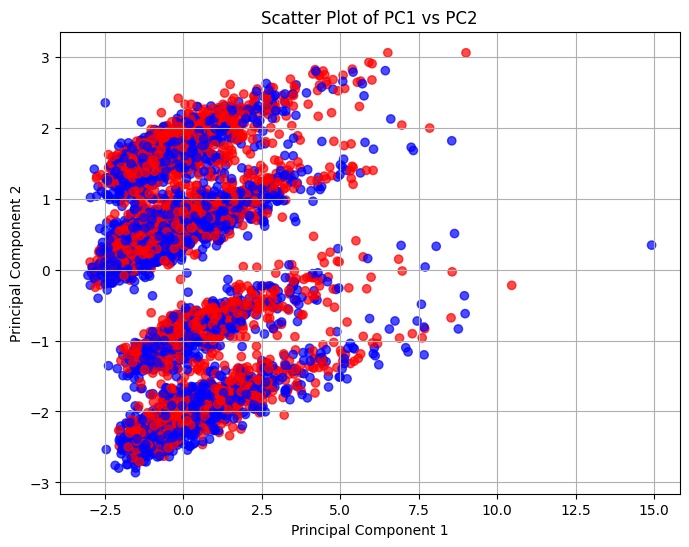

In [35]:
plt.figure(figsize=(8, 6))

# Assuming `loandf['good_bad_loan']` is the dependent variable
# Ensure `good_bad_loan` is binary or categorical for coloring
colors = loan_df['good_bad_loan'].map({0: 'red', 1: 'blue'})  # Map values to colors (adjust as needed)

plt.scatter(pc_df['PC1'], pc_df['PC2'], c=colors, alpha=0.7)
plt.title('Scatter Plot of PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [36]:
model_features = logreg_model.params.index[1:]

In [37]:
def calculate_risk_score(input_data, model, features):
    # Ensure input data has the same columns as the features used in the model
    input_data = input_data[features]
    
    # Add the constant (intercept) to the input data for prediction
    input_data_sm = sm.add_constant(input_data)
    
    # Calculate the log odds (predicted logit)
    log_odds = model.predict(input_data_sm)
    
    # Calculate the odds ratio (exponentiate the log odds)
    odds_ratio = np.exp(log_odds)
    
    # Normalize the odds ratio to range [0, 100]
    # Min-Max scaling of odds ratio to [0, 100]
    min_odds = odds_ratio.min()
    max_odds = odds_ratio.max()
    risk_scores = 100 * (odds_ratio - min_odds) / (max_odds - min_odds)
    
    # Return the risk scores
    return risk_scores

In [38]:
import numpy as np

In [39]:
input_data = X_test  # Replace with your desired data (test data or any new input)
risk_scores = calculate_risk_score(input_data, logreg_model, model_features)

In [40]:
risk_scores_df = pd.DataFrame({'Risk Score': risk_scores})
print(risk_scores_df)

      Risk Score
5835   76.633925
5805   60.066347
2373   79.678005
5665   47.678172
701    68.095940
...          ...
2932   70.184045
4115   77.206591
4497   54.985364
587    66.028129
5998   75.897694

[1754 rows x 1 columns]


In [41]:
# Assuming 'risk_scores_df' contains the risk scores

# Count how many risk scores are less than 50
count_low_risk = (risk_scores_df['Risk Score'] < 50).sum()

# Print the result
print(f"Number of individuals with risk score less than 50: {count_low_risk}")

Number of individuals with risk score less than 50: 91
